# Training a Classifier

When you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor` .

* For images, packages such as Pillow, OpenCV are useful
* For audio, packages such as scipy and librosa
* For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful


Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

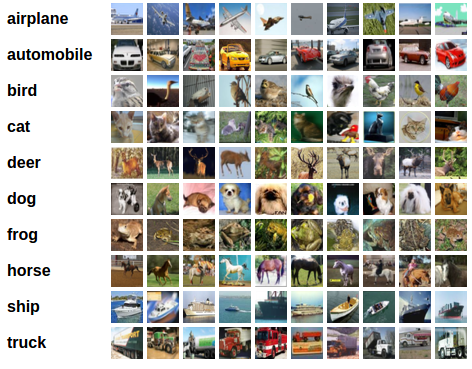


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using `torchvision`

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='/data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


Extracting /data/cifar-10-python.tar.gz to /data


Let us show some of the training images, for fun.



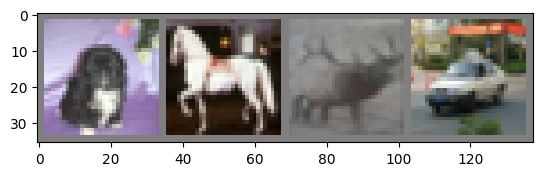

dog   horse deer  car  


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()

  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In this `imshow` function, unnormalization is necessary to **reverse the normalization** applied to the images so that they can be displayed in their original (or visually interpretable) form.

### Why Unnormalize?
When you apply normalization to images during preprocessing (as in your previous code with `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`), the pixel values of each channel are shifted and scaled to the range \([-1, 1]\). This range is beneficial for neural network training but doesn’t display well for human interpretation.

So, before displaying the image, it needs to be **unnormalized** to bring the pixel values back to their original range \([0, 1]\), which can be visualized correctly by `matplotlib`.

### How the Unnormalization Works
The line:
```python
img = img / 2 + 0.5
```
does the following:
- **Dividing by 2**: Since the original normalization was done by subtracting 0.5 and then dividing by 0.5, reversing this operation requires multiplying by the standard deviation (0.5), which is the same as dividing by 2.
- **Adding 0.5**: This shifts the pixel values back up to the \([0, 1]\) range.

### Step-by-Step Explanation of `imshow`
1. **Unnormalize**:
   ```python
   img = img / 2 + 0.5
   ```
   This reverses the normalization so the image is in a displayable range.

2. **Convert to Numpy Array**:
   ```python
   npimg = img.numpy()
   ```
   Converts the PyTorch tensor to a NumPy array, which is required for `matplotlib`.

3. **Transpose for Display**:
   ```python
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   ```
   - PyTorch tensors use the channel-first format \((C, H, W)\), while `matplotlib` expects channel-last format \((H, W, C)\).
   - `np.transpose(npimg, (1, 2, 0))` rearranges the dimensions so that the image can be displayed correctly.

In summary, **unnormalization** is needed to return the image pixel values to a visually interpretable range before displaying, as the neural network-friendly \([-1, 1]\) range isn't suitable for direct visualization.

## 2. Define a Convolutional Neural Network



In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): # inheritance from nn.Module class

  def __init__(self):
    super().__init__() # Python also has a super() function that will make the child class inherit all the methods and properties from its parent:
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

More info about Cross Entropy loss: https://medium.com/@omerkaanvural/cross-entropy-loss-nedir-56805a94cb09

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [19]:
for epoch in range(2): # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):

    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item() # sace loss deseydik tuple olurdu o yüzden loss.item() diyoruz.

    if i % 2000 == 1999:    # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 1.820
[1,  4000] loss: 1.660
[1,  6000] loss: 1.590
[1,  8000] loss: 1.525
[1, 10000] loss: 1.478
[1, 12000] loss: 1.415
[2,  2000] loss: 1.359
[2,  4000] loss: 1.354
[2,  6000] loss: 1.319
[2,  8000] loss: 1.298
[2, 10000] loss: 1.238
[2, 12000] loss: 1.227
Finished Training


In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

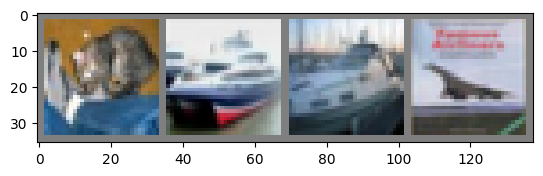

GroundTruth:  cat   ship  ship  plane


In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [28]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [29]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Let us look at how the network performs on the whole dataset.



In [38]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 4 veriyor cunlu batch_size 4'e eşit.
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


The line `total += labels.size(0)` is used here to count the **number of images (or samples) in the current batch**. In PyTorch, `labels.size(0)` returns the size of the first dimension of the `labels` tensor, which is the **batch size** (i.e., the number of samples in this batch). By accumulating this count across all batches, we get the **total number of samples** in the entire test dataset.

### Why `labels.size(0)`?
- `labels` is a tensor containing the ground-truth labels for each image in the batch. For example, if the batch size is 4, `labels` might look like `[3, 1, 4, 0]` where each value is a label for one image in the batch.
- `labels.size(0)` (or equivalently `labels.shape[0]`) gives the number of elements along the first dimension, which in this case is the batch size (4).

### Example
If `testloader` gives batches of 4 images, each iteration will load 4 images, and `labels.size(0)` will return `4`. Here’s a simplified breakdown:

1. **First Batch**: 4 images → `total += 4`
2. **Second Batch**: 4 images → `total += 4`
3. **...** Continue for all batches until the test set is fully iterated.

By summing `labels.size(0)` across all batches, we get the total number of test images, which allows us to calculate the accuracy over the entire test dataset.

### Why We Need This
This approach makes the code flexible to different batch sizes. So, whether `testloader` has batch sizes of 4, 32, or any other number, `total` will still correctly represent the number of images in the dataset.

That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [40]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.2 %
Accuracy for class: car   is 75.9 %
Accuracy for class: bird  is 47.7 %
Accuracy for class: cat   is 19.7 %
Accuracy for class: deer  is 37.3 %
Accuracy for class: dog   is 40.4 %
Accuracy for class: frog  is 77.2 %
Accuracy for class: horse is 67.2 %
Accuracy for class: ship  is 70.1 %
Accuracy for class: truck is 54.6 %
